# References

* http://leon.bottou.org/publications/pdf/compstat-2010.pdf
* http://research.microsoft.com/pubs/192769/tricks-2012.pdf
* http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1257413&tag=1
* http://www.sciencedirect.com/science/article/pii/S0305048301000263

In [61]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information deap, matplotlib, numpy, pandas, pymc3, seaborn, sklearn, theano

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software,Version
Python,3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,4.1.2
OS,Linux 3.13.0 86 generic x86_64 with debian jessie sid
deap,1.0
matplotlib,1.5.1
numpy,1.10.4
pandas,0.18.0
pymc3,3.0
seaborn,0.7.0
sklearn,0.17.1


In [62]:
from nsga2 import *
from IPython.display import display
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import random
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing as preproc
from sklearn import svm
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr, mean_absolute_error as mae

np.set_printoptions(threshold=np.nan)
sns.set()

In [99]:
path = '../btc-data/BTC_LOB_techind_10s.csv'
data10s = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_30s.csv'
data30s = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_60s.csv'
data1m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_300s.csv'
data5m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_600s.csv'
data10m = pd.read_csv(path, index_col = 0, parse_dates = True)

datas = [data10s, data30s, data1m, data5m, data10m]

In [74]:
def directional_symmetry(act, pred):
    act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else 0, zip(act.values, act.values[1:])))
    pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else 0, zip(pred, pred[1:])))
    d = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    
    return np.sum(d) / len(act_ticks)

In [91]:
#def filter_features(mask):
#    return list(map(lambda t: t[1], filter(lambda t: t[0], zip(mask, FEATURES))))

def fitness_fun(model):
    method, indiv, dataset = model
    loss = ['epsilon_insensitive', 'squared_epsilon_insensitive']
    penalty = ['none', 'l2', 'l1', 'elasticnet']
    learning_rate = ['constant', 'optimal', 'invscaling']
    
    X_train, X_valid, y_train, y_valid = dataset
    
    #print(X_train.columns)
    
    # Train the learner on the training data
    # and evaluate the performance by the test data
    
    if indiv[1] <= 0:
        indiv[1] = 0.002
    
    if indiv[0] <= 0:
        indiv[0] = 0.002
        
    method.loss = loss[int(indiv[3])]
    method.penalty = penalty[int(indiv[4])]
    method.learning_rate = learning_rate[int(indiv[6])]
    
    if method.learning_rate in ['constant', 'invscaling']:
        method.eta0 = indiv[1]
        
        if method.learning_rate == 'invscaling':
            method.power_t = indiv[2]
    else:
        method.alpha = indiv[0]
        
    if method.penalty == 'elasticnet':
        method.l1_ratio = indiv[5]
    
    method.fit(X_train, y_train)
    
    X_valid25 = X_valid[:int(0.2*len(X_valid))]
    y_valid25 = y_valid[:int(0.2*len(y_valid))]
    
    pred = method.predict(X_valid)
    rmse = np.sqrt(mse(y_valid, pred))
    dir_sym = directional_symmetry(y_valid, pred)
    
    return dir_sym, rmse

def nsga2_feat_sel(method, gen_num, indiv_num, dataset):
    creator.create("FitnessMulti", base.Fitness, weights = (1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)
    toolb.register('alpha', random.uniform, 0.0001, 0.01)
    toolb.register('eta0', random.uniform, 0.0001, 0.01)
    toolb.register('power_t', random.uniform, 0.001, 0.5)
    toolb.register('loss', random.randint, 0, 1)
    toolb.register('penalty', random.randint, 0, 3)
    toolb.register('l1_ratio', random.uniform, 0, 1)
    toolb.register('learning_rate', random.randint, 0, 2)
    toolb.register('individual', tools.initCycle, creator.Individual,
                   (toolb.alpha, toolb.eta0, toolb.power_t, toolb.loss,
                    toolb.penalty, toolb.l1_ratio, toolb.learning_rate), n = 1)
    toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
    toolb.register('evaluate', fitness_fun)
    toolb.register('mate', tools.cxUniform, indpb = 0.1)
    toolb.register('mutate', tools.mutGaussian, mu = 0.001, sigma = 0.01, indpb = 0.1)
    toolb.register('select', tools.selNSGA2)

    population = toolb.population()
    fits = map (toolb.evaluate, map(lambda x: (method, x, dataset), population))

    hof = tools.HallOfFame(1)

    for fit, ind in zip(fits, population):
        ind.fitness.values = fit

    best = np.ndarray((gen_num, 2))
    top_RMSE = []

    for gen in range(gen_num):
        offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.55, mutpb = 0.15)
        hof.update(offspring)

        fits = map (toolb.evaluate, map(lambda x: (method, x, dataset), offspring))

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolb.select(offspring + population, k = indiv_num)

        best[gen] = (hof[0].fitness.values)
        top_RMSE = hof[0]

    chromosome = hof[0]
    #selected_features = list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], CHARTS[1:]))))
    
    return best, chromosome

In [109]:
def feature_selection(gen_num, indiv_num, dataset):
    
    sgd = linear_model.SGDRegressor(epsilon = 0.0, shuffle = False)

    results = nsga2_feat_sel(sgd, gen_num, indiv_num, dataset)

    print ('Scores', results[0], '\n')
    print ('Chromosome: ', results[1], '\n\n')
    
    # Create dataframes from the metrics
    results_df = pd.DataFrame(results[0], columns = ['DS', 'RMSE'])
    results_df.insert(0, 'Generation', results_df.index)
    
    # Plot the best individuals of each generation based on the metrics
    g = sns.PairGrid(results_df, y_vars=['DS', 'RMSE'], x_vars = 'Generation', size=7, aspect = 2.5)
    g.map(plt.plot)

In [120]:
def evaluate(data, features):
    X, y = data[features], data['DELTAP'].copy()

    for df in X.columns.tolist():
        X[df] = preproc.StandardScaler().fit(X[df].reshape(-1,1)).transform(X[df].reshape(-1,1))

    train_dates = X.index[:int(0.7*len(X))]
    valid_dates = X.index[int(0.7*len(X)):int(0.85*len(X))]
    test_dates = X.index[int(0.85*len(X)):]

    X_train = X[train_dates[0]:train_dates[-1]]
    y_train = y[train_dates[0]:train_dates[-1]]

    X_valid = X[valid_dates[0]:valid_dates[-1]]
    y_valid = y[valid_dates[0]:valid_dates[-1]]
    
    dataset = X_train, X_valid, y_train, y_valid
    
    feature_selection(25, 12, dataset)

    X_test = X[test_dates[0]:test_dates[-1]]
    y_test = y[test_dates[0]:test_dates[-1]]

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Scores [[ 0.59732494  0.08303244]
 [ 0.86035723  0.08008951]
 [ 0.86035723  0.08008951]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]
 [ 0.86750432  0.08226729]] 

Chromosome:  [0.008019669427699848, 0.002990851700931255, 0.316095176145151, -0.002914406041944242, 2, 0.12999520558388655, 0] 




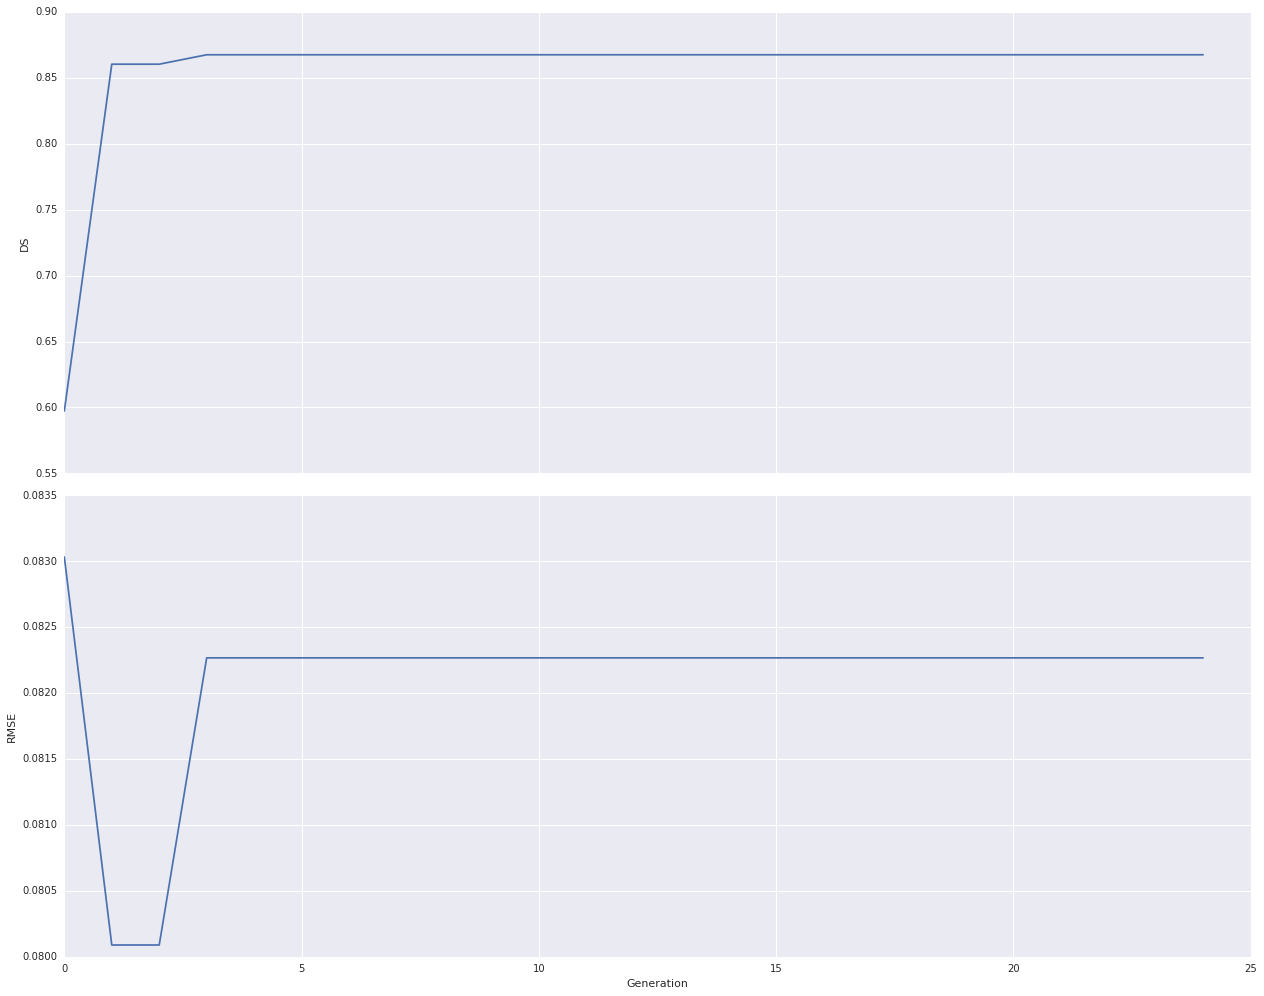

In [121]:
features = ['B-ASPREAD', 'K360', 'K180',
            'MOM60', 'ROC60', 'LWR360',
            'LWR180', 'ADOSC360', 'ADOSC180',
            'DISP360', 'DISP180', 'DISP60',
            'OSCP60-180', 'RSI60']

evaluate(datas[0].copy(), features)

0.106500379971
0.123099661097
0.863370089593


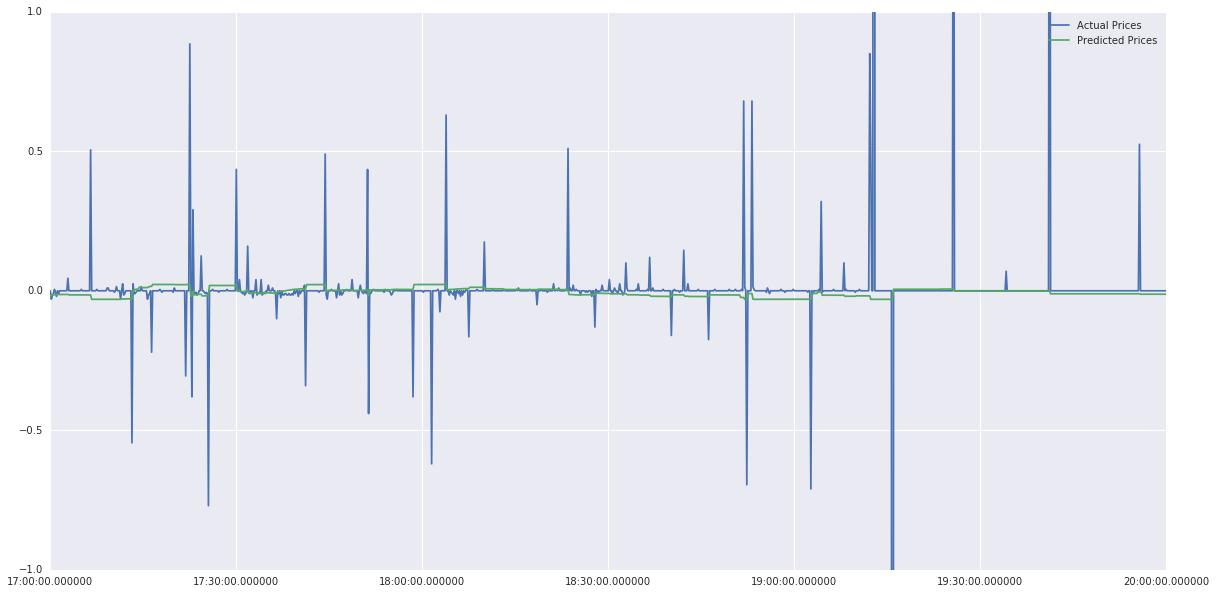

In [131]:
X, y = data10s[features].copy(), data10s['DELTAP'].copy()

for df in X.columns.tolist():
    X[df] = preproc.StandardScaler().fit(X[df].reshape(-1,1)).transform(X[df].reshape(-1,1))

train_dates = X.index[:int(0.7*len(X))]
valid_dates = X.index[int(0.7*len(X)):int(0.85*len(X))]
test_dates = X.index[int(0.85*len(X)):]

X_train = X[train_dates[0]:valid_dates[-1]]
y_train = y[train_dates[0]:valid_dates[-1]]

sgd = linear_model.SGDRegressor(epsilon = 0.0, shuffle = False, loss='epsilon_insensitive',
                                penalty = 'l1', learning_rate = 'constant',
                                alpha = 0.008019669427699848, eta0 = 0.002990851700931255,
                                power_t = 0.316095176145151, l1_ratio = 0.12999520558388655)

sgd.fit(X_train, y_train)

X_valid = X[valid_dates[0]:valid_dates[-1]]
y_valid = y[valid_dates[0]:valid_dates[-1]]

X_test = X[test_dates[0]:test_dates[-1]]
y_test = y[test_dates[0]:test_dates[-1]]

pred = sgd.predict(X_test)

rmse_test = np.sqrt(mse(y_test, pred))
rmse_train = np.sqrt(mse(y_train, sgd.predict(X_train)))

print(rmse_test)
print(rmse_train)

print(directional_symmetry(y_test, pred))

plt.figure(figsize = (20,10))
plt.plot(y_test.index, y_test, label = 'Actual Prices')
plt.plot(y_test.index, pred, label = 'Predicted Prices')
plt.xlim('2016-04-24 17', '2016-04-24 20')
plt.ylim(-1,1)
plt.legend()

In [ ]:
clf = svm.LinearSVR(C = 5000, loss='epsilon_insensitive', max_iter = 100)
clf.fit(X_train, y_train)

In [ ]:
clf = svm.SVR(C = 50, kernel = 'rbf', max_iter = 10, cache_size = 10000)
clf.fit(X_train, y_train)

In [ ]:
pred = clf.predict(X_test)
di

In [ ]:
R2 = clf.score(X_test, y_test)
R2
rmse_test = np.sqrt(mse(y_test, pred))
rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))

print(rmse_test)
print(rmse_train)

In [ ]:
clf = linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='l2',
                                epsilon=0, shuffle = True,
                                eta0=0.002, power_t = 0.0759965388605597)
clf.fit(X_train, y_train)

In [55]:
pred = clf.predict(X_test)
directional_symmetry(y_test, pred)

0.62537053682418864

In [56]:
R2 = clf.score(X_test, y_test)
R2
rmse_test = np.sqrt(mse(y_test, pred))
rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))

print(rmse_test)
print(rmse_train)

0.107104633804
0.130407170283


In [ ]:
plt.figure(figsize = (20,10))
plt.plot(y_test.index, y_test, label = 'Actual Prices')
plt.plot(y_test.index, pred, label = 'Predicted Prices')
#plt.xlim('2016-04-24 19', '2016-04-24 21')
#plt.ylim(445, 480)
plt.legend()

In [57]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)

pred = dr.predict(X_test)
print(directional_symmetry(y_test, pred))

rmse_test = np.sqrt(mse(y_test, pred))
rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))

print(rmse_test)
print(rmse_train)

0.854201329789
35.7886766934
0.130407170283


In [ ]:
plt.figure(figsize = (20,10))
plt.plot(y_test.index, y_test, label = 'Actual Prices')
plt.plot(y_test.index, pred, label = 'Predicted Prices')
#plt.xlim('2016-04-24 19', '2016-04-24 21')
#plt.ylim(445, 480)
plt.legend()

In [59]:
np.mean(list(map(lambda t: np.abs(t[1] - t[0]), zip(y_test.values, y_test.values[1:]))))

0.022259525585368579